<a href="https://colab.research.google.com/github/ZealPower22/Text-detection-and-extarction-beginner-/blob/main/Text_detection_and_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.5 MB/s eta 0:00:00


In [6]:
import os
import random
from faker import Faker
from PIL import Image, ImageDraw, ImageFont

# Define directories
output_dir = "small_text_dataset"
images_dir = os.path.join(output_dir, "images")
labels_dir = os.path.join(output_dir, "labels")

# Create directories
os.makedirs(images_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)

# Initialize Faker for generating random text
fake = Faker()

# Define image parameters
IMG_WIDTH, IMG_HEIGHT = 300, 300
NUM_IMAGES = 10  # Small dataset with 10 images
FONT_PATHS = [
    "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf",  # Linux
    "C:/Windows/Fonts/arial.ttf",  # Windows
    "/Library/Fonts/Arial.ttf"  # Mac
]
FONT_SIZE = 18

# Try to load the font, fallback to default if unavailable
def get_font():
    for path in FONT_PATHS:
        if os.path.exists(path):
            return ImageFont.truetype(path, FONT_SIZE)
    print("⚠️ Font not found, using default font.")
    return ImageFont.load_default()

# Load the font
font = get_font()

# Generate dataset
for i in range(NUM_IMAGES):
    # Create blank image with random background color
    img = Image.new("RGB", (IMG_WIDTH, IMG_HEIGHT), color=(random.randint(220, 255), random.randint(220, 255), random.randint(220, 255)))
    draw = ImageDraw.Draw(img)

    # Generate random text
    text = fake.word()

    # Get text size using textbbox()
    bbox = draw.textbbox((0, 0), text, font=font)
    text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]

    # Randomly position the text
    x_min = random.randint(10, IMG_WIDTH - text_width - 10)
    y_min = random.randint(10, IMG_HEIGHT - text_height - 10)
    x_max = x_min + text_width
    y_max = y_min + text_height

    # Draw text on image
    draw.text((x_min, y_min), text, font=font, fill=(0, 0, 0))

    # Save image
    image_filename = f"text_img_{i + 1}.jpg"
    img.save(os.path.join(images_dir, image_filename))

    # Save YOLO annotation (class_id, x_center, y_center, width, height normalized)
    x_center = (x_min + x_max) / 2 / IMG_WIDTH
    y_center = (y_min + y_max) / 2 / IMG_HEIGHT
    box_width = (x_max - x_min) / IMG_WIDTH
    box_height = (y_max - y_min) / IMG_HEIGHT

    label_filename = f"text_img_{i + 1}.txt"
    with open(os.path.join(labels_dir, label_filename), "w") as f:
        f.write(f"0 {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}\n")

print(f"✅ Small dataset generated successfully! Images and labels saved in '{output_dir}'")


⚠️ Font not found, using default font.
✅ Small dataset generated successfully! Images and labels saved in 'small_text_dataset'


In [8]:
!pip install Pillow faker pytesseract scikit-learn


In [11]:
!apt-get update
!apt-get install -y tesseract-ocr


Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,237 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,692 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Pac

In [12]:
pytesseract.pytesseract.tesseract_cmd = "/usr/bin/tesseract"



In [13]:
import os
import platform
import pytesseract
import numpy as np
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# ✅ Set Tesseract path dynamically based on OS
if platform.system() == "Windows":
    pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
elif platform.system() == "Darwin":  # macOS
    pytesseract.pytesseract.tesseract_cmd = "/usr/local/bin/tesseract"
else:  # Linux
    pytesseract.pytesseract.tesseract_cmd = "/usr/bin/tesseract"

# 📂 Define dataset path
images_dir = "small_text_dataset/images"
if not os.path.exists(images_dir):
    raise FileNotFoundError(f"❌ Error: The directory '{images_dir}' does not exist. Generate the dataset first!")

# ✅ Define categories and labels
categories = ["tech", "food", "sports", "fashion"]
NUM_IMAGES = 10  # Number of generated images

# 📸 Extracted text and labels
extracted_texts = []
labels = []

# 🔎 Extract text from generated images and assign labels
for i in range(NUM_IMAGES):
    image_path = os.path.join(images_dir, f"text_img_{i + 1}.jpg")

    if not os.path.exists(image_path):
        print(f"⚠️ Warning: File '{image_path}' not found. Skipping...")
        continue

    # Extract text using Tesseract
    extracted_text = pytesseract.image_to_string(Image.open(image_path)).strip()

    # Check if extracted text is empty
    if not extracted_text:
        print(f"⚠️ Warning: No text found in '{image_path}', assigning default text.")
        extracted_text = "default"

    extracted_texts.append(extracted_text)

    # Assign random labels cyclically for simplicity
    label = i % len(categories)  # Rotating category labels
    labels.append(label)

print("✅ Text extracted from images successfully!")

# 🔢 Convert text to feature vectors using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(extracted_texts)  # Vectorize extracted text
y = np.array(labels)

# 🎯 Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🧠 Train Naive Bayes Classifier
model = MultinomialNB()
model.fit(X_train, y_train)

# 📊 Make predictions and calculate accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"🎉 Model Accuracy: {accuracy * 100:.2f}%")

# 🕵️ Test with a new text sample
new_text = "pizza"  # Sample text to classify
new_text_vectorized = vectorizer.transform([new_text])
predicted_label = model.predict(new_text_vectorized)[0]
predicted_category = categories[predicted_label]

print(f"🍕 The word '{new_text}' is classified under '{predicted_category}'!")


⚠️ Warning: No text found in 'small_text_dataset/images/text_img_5.jpg', assigning default text.
⚠️ Warning: No text found in 'small_text_dataset/images/text_img_7.jpg', assigning default text.
⚠️ Warning: No text found in 'small_text_dataset/images/text_img_9.jpg', assigning default text.
✅ Text extracted from images successfully!
🎉 Model Accuracy: 50.00%
🍕 The word 'pizza' is classified under 'tech'!


In [15]:
!apt-get update
!apt-get install -y fonts-dejavu-core


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [16]:
from PIL import Image, ImageDraw, ImageFont

# Use a system font that exists
FONT_PATH = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"
FONT_SIZE = 20

# Load font correctly
try:
    font = ImageFont.truetype(FONT_PATH, FONT_SIZE)
except OSError:
    print("⚠️ Font not found, using default font.")
    font = ImageFont.load_default()


In [20]:
import os
import random
import json
from faker import Faker
from PIL import Image, ImageDraw, ImageFont

# Define directories
output_dir = "text_dataset"
images_dir = os.path.join(output_dir, "images")
annotations_dir = os.path.join(output_dir, "annotations")

# Create directories
os.makedirs(images_dir, exist_ok=True)
os.makedirs(annotations_dir, exist_ok=True)

# Initialize Faker for generating random text
fake = Faker()

# Define image parameters
IMG_WIDTH, IMG_HEIGHT = 640, 480
NUM_IMAGES = 100  # Number of images to generate
FONT_PATH = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"  # Change if needed
FONT_SIZE = 20

# Create annotations dictionary for COCO format
annotations = {"images": [], "annotations": [], "categories": [{"id": 1, "name": "text"}]}
annotation_id = 1

for i in range(NUM_IMAGES):
    # Create blank image with random background color
    img = Image.new("RGB", (IMG_WIDTH, IMG_HEIGHT), color=(random.randint(200, 255), random.randint(200, 255), random.randint(200, 255)))
    draw = ImageDraw.Draw(img)

    # Generate random text
    text = fake.sentence(nb_words=random.randint(2, 6))
    font = ImageFont.truetype(FONT_PATH, FONT_SIZE)

    # ✅ Get text size using textbbox()
    bbox = draw.textbbox((0, 0), text, font=font)
    text_width, text_height = bbox[2] - bbox[0], bbox[3] - bbox[1]

    # ✅ Check if the text fits within the image dimensions
    if text_width >= IMG_WIDTH - 20 or text_height >= IMG_HEIGHT - 20:
        print(f"⚠️ Skipping text that doesn't fit in image: '{text}'")
        continue

    # Generate random coordinates to place the text
    x_min = random.randint(10, IMG_WIDTH - text_width - 10)
    y_min = random.randint(10, IMG_HEIGHT - text_height - 10)
    x_max = x_min + text_width
    y_max = y_min + text_height

    # Draw text on image
    draw.text((x_min, y_min), text, font=font, fill=(0, 0, 0))

    # Save image
    image_filename = f"text_image_{i + 1}.jpg"
    img.save(os.path.join(images_dir, image_filename))

    # Add image to COCO annotations
    annotations["images"].append({
        "id": i + 1,
        "file_name": image_filename,
        "width": IMG_WIDTH,
        "height": IMG_HEIGHT
    })

    # Add bounding box annotation
    annotations["annotations"].append({
        "id": annotation_id,
        "image_id": i + 1,
        "category_id": 1,
        "bbox": [x_min, y_min, text_width, text_height],
        "area": text_width * text_height,
        "iscrowd": 0
    })
    annotation_id += 1

# Save annotations in COCO format
with open(os.path.join(annotations_dir, "annotations.json"), "w") as f:
    json.dump(annotations, f, indent=4)

print(f"✅ Dataset generated successfully! Images and annotations saved in '{output_dir}'")


✅ Dataset generated successfully! Images and annotations saved in 'text_dataset'


In [21]:
import os
import json
import pytesseract
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Define dataset directories
output_dir = "text_dataset"
images_dir = os.path.join(output_dir, "images")
annotations_path = os.path.join(output_dir, "annotations", "annotations.json")

# Load annotations
with open(annotations_path, "r") as f:
    annotations = json.load(f)

# Extract text from images and prepare dataset
texts = []
labels = []  # We'll classify based on text length (just for demo purposes)

for img_info in annotations["images"]:
    image_path = os.path.join(images_dir, img_info["file_name"])

    # Load image
    img = Image.open(image_path)

    # Extract text using pytesseract
    extracted_text = pytesseract.image_to_string(img).strip()

    # Skip empty text
    if extracted_text:
        texts.append(extracted_text)

        # Dummy labels based on text length (for simplicity)
        if len(extracted_text) < 50:
            labels.append(0)  # Short text
        else:
            labels.append(1)  # Long text

# Check if we have enough data
if len(texts) < 10:
    raise ValueError("Not enough valid text data for classification. Try generating more images.")

# Convert text data to Bag of Words (BoW) using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.25, random_state=42)

# Create and train Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Make predictions
y_pred = nb_classifier.predict(X_test)

# Evaluate the model
print("✅ Model Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

# Test with a new image
def predict_text_category(image_path):
    img = Image.open(image_path)
    extracted_text = pytesseract.image_to_string(img).strip()
    if not extracted_text:
        print("⚠️ No text detected in the image.")
        return

    # Transform the text to BoW representation
    X_new = vectorizer.transform([extracted_text])
    prediction = nb_classifier.predict(X_new)[0]

    if prediction == 0:
        print(f"📝 Prediction: Short text detected.")
    else:
        print(f"📚 Prediction: Long text detected.")

# Example usage:
# predict_text_category("text_dataset/images/text_image_5.jpg")


✅ Model Accuracy: 0.88

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94        24
           1       0.00      0.00      0.00         1

    accuracy                           0.88        25
   macro avg       0.48      0.46      0.47        25
weighted avg       0.92      0.88      0.90        25



In [22]:
import os
import json
import pytesseract
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define dataset directories
output_dir = "text_dataset"
images_dir = os.path.join(output_dir, "images")
annotations_path = os.path.join(output_dir, "annotations", "annotations.json")

# Load annotations
with open(annotations_path, "r") as f:
    annotations = json.load(f)

# Extract text from images and prepare dataset
texts = []
text_lengths = []  # Length of the extracted text (target for regression)

for img_info in annotations["images"]:
    image_path = os.path.join(images_dir, img_info["file_name"])

    # Load image
    img = Image.open(image_path)

    # Extract text using pytesseract
    extracted_text = pytesseract.image_to_string(img).strip()

    # Skip empty text
    if extracted_text:
        texts.append(extracted_text)
        text_lengths.append(len(extracted_text))  # Target value: text length

# Check if we have enough data
if len(texts) < 10:
    raise ValueError("Not enough valid text data for regression. Try generating more images.")

# Convert text data to Bag of Words (BoW) using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, text_lengths, test_size=0.25, random_state=42)

# Create and train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ Mean Squared Error (MSE): {mse:.2f}")
print(f"📊 R-squared (R²): {r2:.2f}")

# Test with a new image
def predict_text_length(image_path):
    img = Image.open(image_path)
    extracted_text = pytesseract.image_to_string(img).strip()

    if not extracted_text:
        print("⚠️ No text detected in the image.")
        return

    # Transform the text to BoW representation
    X_new = vectorizer.transform([extracted_text])
    predicted_length = lr_model.predict(X_new)[0]

    print(f"📝 Predicted Text Length: {int(predicted_length)} characters")

# Example usage:
# predict_text_length("text_dataset/images/text_image_5.jpg")


✅ Mean Squared Error (MSE): 160.05
📊 R-squared (R²): 0.01


In [23]:
import os
import json
import pytesseract
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define dataset directories
output_dir = "text_dataset"
images_dir = os.path.join(output_dir, "images")
annotations_path = os.path.join(output_dir, "annotations", "annotations.json")

# Load annotations
with open(annotations_path, "r") as f:
    annotations = json.load(f)

# Extract text from images and prepare dataset
texts = []
text_lengths = []  # Length of the extracted text (target for regression)

for img_info in annotations["images"]:
    image_path = os.path.join(images_dir, img_info["file_name"])

    # Load image
    img = Image.open(image_path)

    # Extract text using pytesseract
    extracted_text = pytesseract.image_to_string(img).strip()

    # Skip empty text
    if extracted_text:
        texts.append(extracted_text)
        text_lengths.append(len(extracted_text))  # Target value: text length

# Check if we have enough data
if len(texts) < 10:
    raise ValueError("Not enough valid text data for regression. Try generating more images.")

# Convert text data to Bag of Words (BoW) using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, text_lengths, test_size=0.25, random_state=42)

# Create and train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ Mean Squared Error (MSE): {mse:.2f}")
print(f"📊 R-squared (R²): {r2:.2f}")

# Test with a new image
def predict_text_length(image_path):
    img = Image.open(image_path)
    extracted_text = pytesseract.image_to_string(img).strip()

    if not extracted_text:
        print("⚠️ No text detected in the image.")
        return

    # Transform the text to BoW representation
    X_new = vectorizer.transform([extracted_text])
    predicted_length = lr_model.predict(X_new)[0]

    print(f"📝 Predicted Text Length: {int(predicted_length)} characters")

# Example usage:
# predict_text_length("text_dataset/images/text_image_5.jpg")


✅ Mean Squared Error (MSE): 160.05
📊 R-squared (R²): 0.01


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


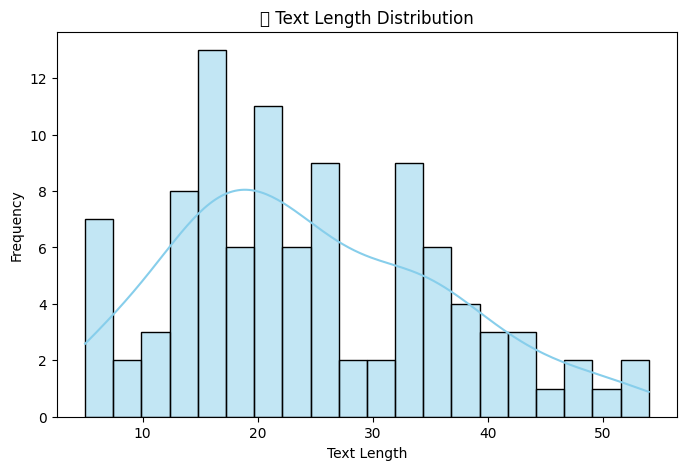

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


✅ Accuracy: 100.00%

📊 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        25

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


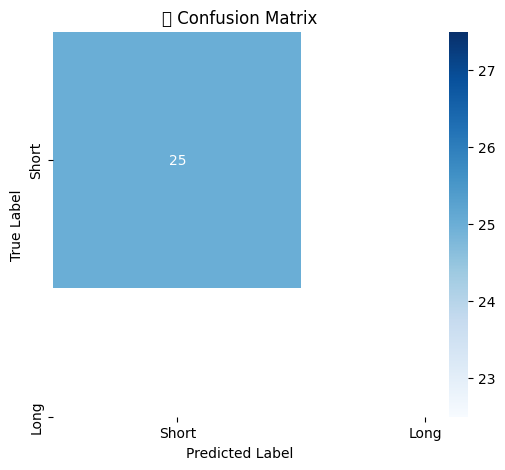

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


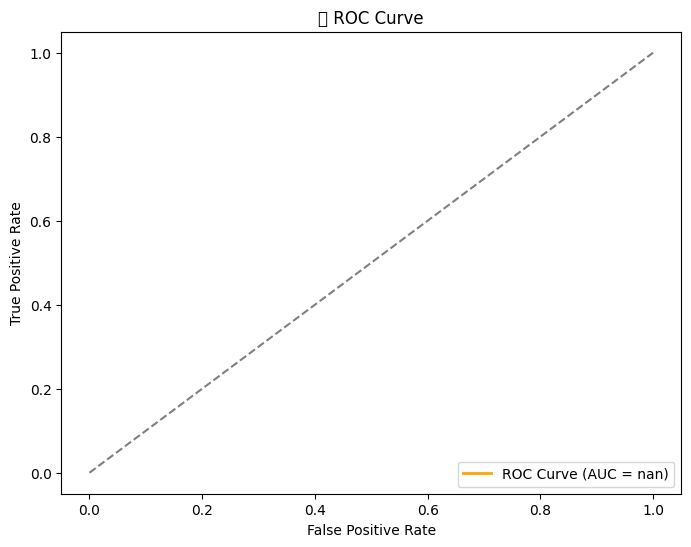

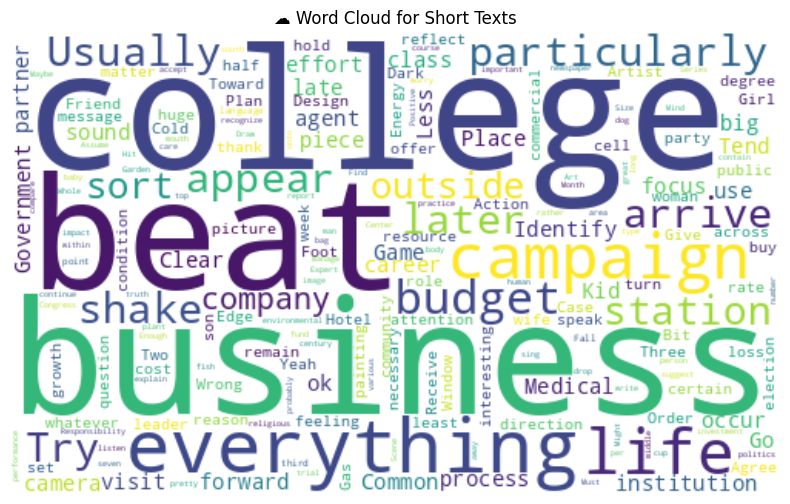

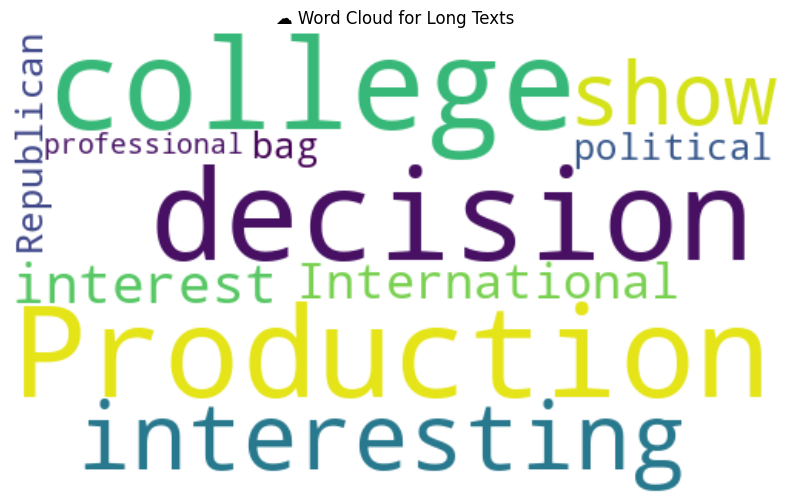

In [24]:
import os
import json
import pytesseract
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Define dataset directories
output_dir = "text_dataset"
images_dir = os.path.join(output_dir, "images")
annotations_path = os.path.join(output_dir, "annotations", "annotations.json")

# Load annotations
with open(annotations_path, "r") as f:
    annotations = json.load(f)

# Extract text from images and prepare dataset
texts = []
labels = []  # Binary label: 0 = short text, 1 = long text

# Define length threshold to classify text
LENGTH_THRESHOLD = 50  # Texts longer than 50 characters are considered "long"

for img_info in annotations["images"]:
    image_path = os.path.join(images_dir, img_info["file_name"])

    # Load image
    img = Image.open(image_path)

    # Extract text using pytesseract
    extracted_text = pytesseract.image_to_string(img).strip()

    # Skip empty text
    if extracted_text:
        texts.append(extracted_text)

        # Label based on text length
        if len(extracted_text) > LENGTH_THRESHOLD:
            labels.append(1)  # Long text
        else:
            labels.append(0)  # Short text

# Check if we have enough data
if len(texts) < 10:
    raise ValueError("Not enough valid text data for classification. Try generating more images.")

# Visualize Text Length Distribution
plt.figure(figsize=(8, 5))
sns.histplot([len(text) for text in texts], bins=20, kde=True, color='skyblue')
plt.title("📏 Text Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

# Convert text data to Bag of Words (BoW) using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.25, random_state=42)

# Create and train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)
y_prob = lr_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {accuracy * 100:.2f}%")
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Short", "Long"], yticklabels=["Short", "Long"])
plt.title("📊 Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="orange", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.title("📈 ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Generate Word Clouds
short_texts = " ".join([text for text, label in zip(texts, labels) if label == 0])
long_texts = " ".join([text for text, label in zip(texts, labels) if label == 1])

# Word Cloud for Short Texts
plt.figure(figsize=(12, 6))
wc_short = WordCloud(width=500, height=300, background_color="white").generate(short_texts)
plt.imshow(wc_short, interpolation="bilinear")
plt.title("☁️ Word Cloud for Short Texts")
plt.axis("off")
plt.show()

# Word Cloud for Long Texts
plt.figure(figsize=(12, 6))
wc_long = WordCloud(width=500, height=300, background_color="white").generate(long_texts)
plt.imshow(wc_long, interpolation="bilinear")
plt.title("☁️ Word Cloud for Long Texts")
plt.axis("off")
plt.show()

# Test with a new image
def predict_text_class(image_path):
    img = Image.open(image_path)
    extracted_text = pytesseract.image_to_string(img).strip()

    if not extracted_text:
        print("⚠️ No text detected in the image.")
        return

    # Transform the text to BoW representation
    X_new = vectorizer.transform([extracted_text])
    predicted_class = lr_model.predict(X_new)[0]

    # Class prediction
    if predicted_class == 1:
        print(f"📝 Predicted Class: Long Text (>{LENGTH_THRESHOLD} characters)")
    else:
        print(f"📝 Predicted Class: Short Text (<={LENGTH_THRESHOLD} characters)")

# Example usage:
# predict_text_class("text_dataset/images/text_image_5.jpg")
